In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('../data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df
  
#Use the function
df_chunks = adding_remaining_features(df)

In [2]:
df_chunks

,TOC,TN,TP,SS,Flow,Bypass,Rain,sine,cosine,is_weekend,logTOC,logTN,logTP,logSS
DATETIME,,,,,,,,,,,,,,
2020-12-31 23:00:00+00:00,74.554167,29.367552,3.219927,3.713267,1005.133333,0.000007,0.0,-2.588190e-01,0.965926,0,0.071914,0.080307,0.044925,0.301936
2021-01-01 00:00:00+00:00,68.239583,24.129583,2.863656,4.088235,1012.933333,0.000006,0.0,0.000000e+00,1.000000,0,0.066020,0.066448,0.040052,0.327913
2021-01-01 01:00:00+00:00,68.305208,24.448594,2.767479,4.575304,962.500000,0.000014,0.0,2.588190e-01,0.965926,0,0.066081,0.067297,0.038733,0.360678
2021-01-01 02:00:00+00:00,60.715625,25.982396,3.202427,4.691871,927.883333,0.000011,0.0,5.000000e-01,0.866025,0,0.058951,0.071372,0.044686,0.368363
2021-01-01 03:00:00+00:00,62.157292,24.284167,3.012552,5.011011,933.033333,0.000013,0.0,7.071068e-01,0.707107,0,0.060309,0.066859,0.042091,0.389106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 12:00:00+00:00,75.990625,23.000104,6.763969,0.154584,1111.300000,0.000002,0.0,1.224647e-16,-1.000000,0,0.073250,0.063434,0.092144,0.014567
2024-02-20 13:00:00+00:00,71.097917,20.706875,6.111146,0.192213,1160.050000,0.000004,0.0,-2.588190e-01,-0.965926,0,0.068692,0.057287,0.083612,0.018081
2024-02-20 14:00:00+00:00,99.451042,24.020208,4.948927,0.214480,1228.900000,0.000004,0.0,-5.000000e-01,-0.866025,0,0.094822,0.066156,0.068240,0.020155


In [3]:
#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    df_copy = inputdf.copy()
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            df_copy[f'{feature}+{i}'] = df_copy[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            df_copy[f'{feature}-{i}'] = df_copy[f'{feature}'].shift(i)   
    df_copy.dropna(inplace=True)
    return df_copy

In [4]:
#Make a df holding the orginal values
fetures_shift = ["TOC", "TN", "TP", "SS"]
df_origval = dataProcessing_Chunks(df_chunks,fetures_shift,6,6)
#df_origval = dataProcessing_Chunks(df_origval,["Rain"],6,0)

In [5]:
df_origval.drop('Rain', axis=1, inplace=True)
df_origval

,TOC,TN,TP,SS,Flow,Bypass,sine,cosine,is_weekend,logTOC,...,TP-3,TP-4,TP-5,TP-6,SS-1,SS-2,SS-3,SS-4,SS-5,SS-6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-01 05:00:00+00:00,74.140625,27.367812,3.725312,5.595631,830.066667,0.000008,0.965926,2.588190e-01,0,0.071529,...,3.202427,2.767479,2.863656,3.219927,5.359723,5.011011,4.691871,4.575304,4.088235,3.713267
2021-01-01 06:00:00+00:00,65.923958,26.089219,3.375896,4.491904,793.966667,0.000004,1.000000,6.123234e-17,0,0.063849,...,3.012552,3.202427,2.767479,2.863656,5.595631,5.359723,5.011011,4.691871,4.575304,4.088235
2021-01-01 07:00:00+00:00,63.631250,24.883906,3.672448,4.919996,866.266667,0.000008,0.965926,-2.588190e-01,0,0.061696,...,3.396823,3.012552,3.202427,2.767479,4.491904,5.595631,5.359723,5.011011,4.691871,4.575304
2021-01-01 08:00:00+00:00,68.146875,23.861979,3.462083,5.175239,1016.950000,0.000009,0.866025,-5.000000e-01,0,0.065933,...,3.725312,3.396823,3.012552,3.202427,4.919996,4.491904,5.595631,5.359723,5.011011,4.691871
2021-01-01 09:00:00+00:00,75.268750,23.759896,3.970458,5.554139,1067.333333,0.000000,0.707107,-7.071068e-01,0,0.072579,...,3.375896,3.725312,3.396823,3.012552,5.175239,4.919996,4.491904,5.595631,5.359723,5.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 06:00:00+00:00,58.258333,12.971510,2.145208,0.086369,1054.116667,0.000005,1.000000,6.123234e-17,0,0.056631,...,1.204000,0.980802,1.500333,0.978396,0.093327,0.085354,0.077909,0.086143,0.103813,0.122292
2024-02-20 07:00:00+00:00,56.901042,14.129792,1.615833,0.087263,1028.366667,0.000005,0.965926,-2.588190e-01,0,0.055348,...,1.372219,1.204000,0.980802,1.500333,0.086369,0.093327,0.085354,0.077909,0.086143,0.103813
2024-02-20 08:00:00+00:00,66.760417,16.603125,2.601083,0.153545,1076.550000,0.000006,0.866025,-5.000000e-01,0,0.064634,...,1.777781,1.372219,1.204000,0.980802,0.087263,0.086369,0.093327,0.085354,0.077909,0.086143


In [6]:
df_origval.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'sine', 'cosine',
       'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC+1', 'TOC+2',
       'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2', 'TN+3', 'TN+4',
       'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5', 'TP+6', 'SS+1',
       'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6', 'TOC-1', 'TOC-2', 'TOC-3',
       'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4', 'TN-5',
       'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1', 'SS-2',
       'SS-3', 'SS-4', 'SS-5', 'SS-6'],
      dtype='object')

In [7]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

In [8]:
#Split the original
fetures_drop = ['TOC','TN','TP','SS']
X, y = split_dataset(df_origval,fetures_drop,6)

In [9]:
X.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'sine', 'cosine',
       'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC-1', 'TOC-2',
       'TOC-3', 'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4',
       'TN-5', 'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1',
       'SS-2', 'SS-3', 'SS-4', 'SS-5', 'SS-6'],
      dtype='object')

In [10]:
y.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [11]:
X_train = X[:20000]
X_test = X[20000:26683]
y_train = y[:20000]
y_test = y[20000:26683]

In [12]:
X_train.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'sine', 'cosine',
       'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC-1', 'TOC-2',
       'TOC-3', 'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4',
       'TN-5', 'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1',
       'SS-2', 'SS-3', 'SS-4', 'SS-5', 'SS-6'],
      dtype='object')

In [13]:
y_train.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [14]:
X_test

,TOC,TN,TP,SS,Flow,Bypass,sine,cosine,is_weekend,logTOC,...,TP-3,TP-4,TP-5,TP-6,SS-1,SS-2,SS-3,SS-4,SS-5,SS-6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-05-17 09:00:00+00:00,174.926042,41.588020,8.360990,1.515847,790.783333,761.550000,7.071068e-01,-7.071068e-01,0,0.161223,...,9.749396,9.060917,3.928823,4.757667,1.639705,2.042552,2.495021,2.688245,2.779536,2.799963
2023-05-17 10:00:00+00:00,183.506250,47.087032,11.040823,1.275812,1035.033333,919.600000,5.000000e-01,-8.660254e-01,0,0.168500,...,7.170188,9.749396,9.060917,3.928823,1.515847,1.639705,2.042552,2.495021,2.688245,2.779536
2023-05-17 11:00:00+00:00,190.303125,45.181354,14.805656,1.146693,760.666667,843.366667,2.588190e-01,-9.659258e-01,0,0.174227,...,7.479427,7.170188,9.749396,9.060917,1.275812,1.515847,1.639705,2.042552,2.495021,2.688245
2023-05-17 12:00:00+00:00,187.667708,45.342500,15.635594,0.594822,732.500000,477.216667,1.224647e-16,-1.000000e+00,0,0.172010,...,8.360990,7.479427,7.170188,9.749396,1.146693,1.275812,1.515847,1.639705,2.042552,2.495021
2023-05-17 13:00:00+00:00,140.145833,38.335208,9.778562,0.416798,699.450000,0.000000,-2.588190e-01,-9.659258e-01,0,0.131171,...,11.040823,8.360990,7.479427,7.170188,0.594822,1.146693,1.275812,1.515847,1.639705,2.042552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 06:00:00+00:00,58.258333,12.971510,2.145208,0.086369,1054.116667,0.000005,1.000000e+00,6.123234e-17,0,0.056631,...,1.204000,0.980802,1.500333,0.978396,0.093327,0.085354,0.077909,0.086143,0.103813,0.122292
2024-02-20 07:00:00+00:00,56.901042,14.129792,1.615833,0.087263,1028.366667,0.000005,9.659258e-01,-2.588190e-01,0,0.055348,...,1.372219,1.204000,0.980802,1.500333,0.086369,0.093327,0.085354,0.077909,0.086143,0.103813
2024-02-20 08:00:00+00:00,66.760417,16.603125,2.601083,0.153545,1076.550000,0.000006,8.660254e-01,-5.000000e-01,0,0.064634,...,1.777781,1.372219,1.204000,0.980802,0.087263,0.086369,0.093327,0.085354,0.077909,0.086143


In [16]:
# import xgboost as xgb

# # Create the XGBoost model
# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# # Train the XGBoost model
# xgb_model.fit(X_train, y_train)

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid={"random_state": [42],
            "learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],
            'n_estimators': [100,200]}

grid_search = GridSearchCV(xgb.XGBRegressor(),param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=True, n_jobs=-1) 
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': (0.05, 0.1, 0.15),
                         'max_depth': [3, 4, 5, 6, 8],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [100, 200], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [18]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
243,43.936458,4.020942,1.242757,0.023033,0.3,0.2,0.05,3,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.2, 'learn...",-19.849225,-16.518935,-15.169859,-17.179340,1.966590,1
123,54.281601,7.282136,1.379382,0.132528,0.3,0.1,0.05,3,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.1, 'learn...",-19.849890,-16.519018,-15.169733,-17.179547,1.966925,2
3,113.586107,13.333401,3.010170,0.793773,0.3,0.0,0.05,3,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-19.850109,-16.518999,-15.169722,-17.179610,1.967030,3
5,88.765883,7.667547,1.553407,0.224734,0.3,0.0,0.05,3,5,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-19.912961,-16.520109,-15.179853,-17.204308,1.991929,4
245,53.573336,9.715739,1.284919,0.127815,0.3,0.2,0.05,3,5,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.2, 'learn...",-19.912970,-16.520188,-15.180001,-17.204386,1.991874,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,389.943337,17.448569,6.087752,0.785305,0.3,0.0,0.15,8,1,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-21.399916,-18.722212,-15.704857,-18.608995,2.326376,716
233,327.738734,26.458685,4.676115,0.598820,0.3,0.1,0.15,8,1,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.1, 'learn...",-21.391900,-18.748922,-15.694241,-18.611688,2.328083,717
115,343.245747,43.200015,6.023780,1.337302,0.3,0.0,0.15,8,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-21.077667,-18.947982,-15.835174,-18.620274,2.152747,718
355,277.408962,21.872084,5.337383,1.035970,0.3,0.2,0.15,8,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.2, 'learn...",-21.088244,-18.964350,-15.821185,-18.624593,2.163647,719


In [19]:
grid_search.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 200,
 'random_state': 42}

In [20]:
final_model = grid_search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

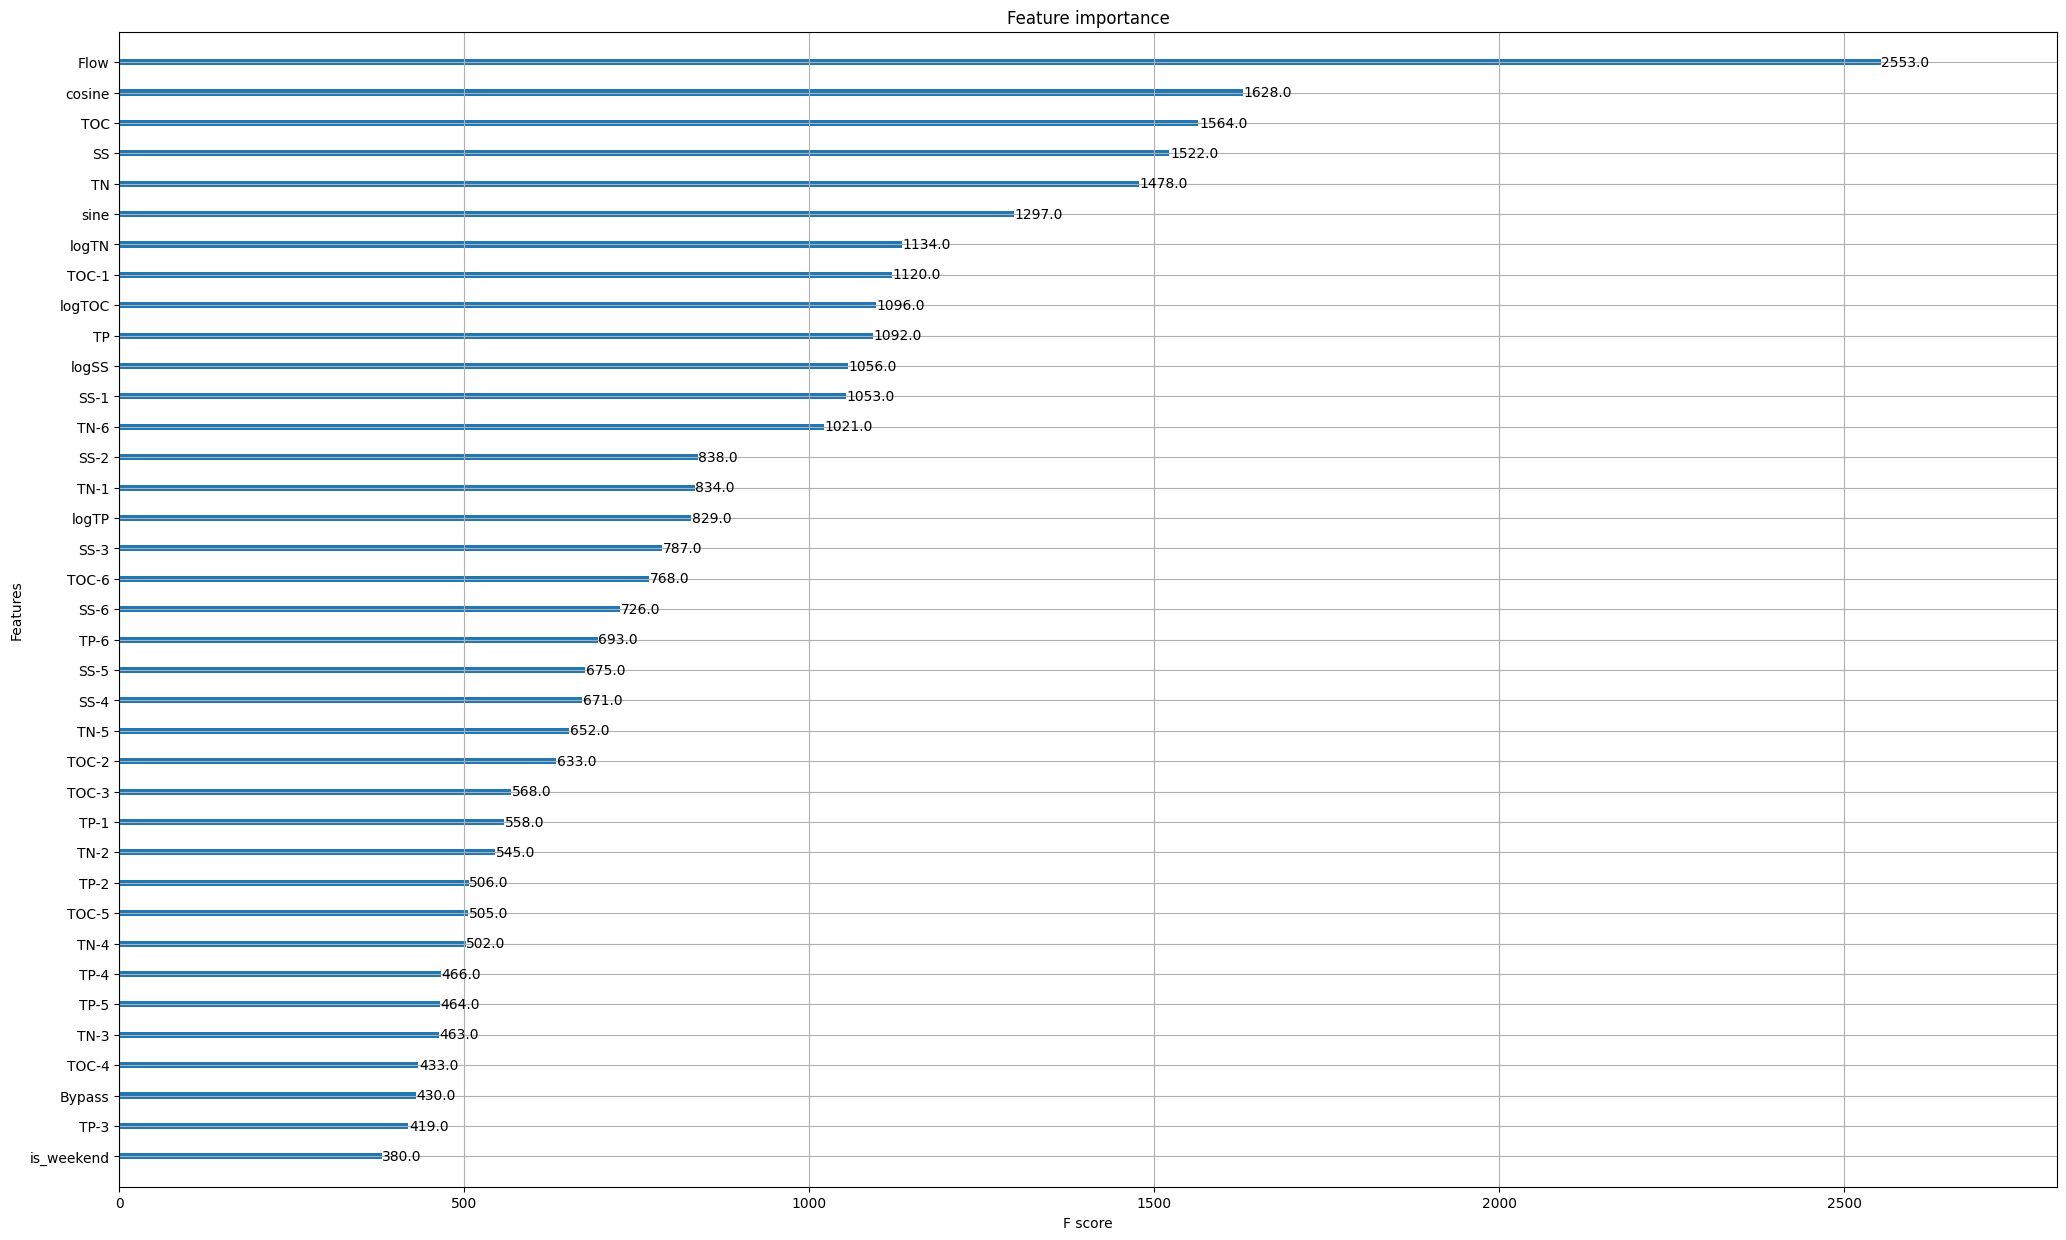

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 15)
xgb.plot_importance(final_model)


In [22]:
xgb_y_pred = final_model.predict(X_test)

In [23]:
dfxgb_y_pred = pd.DataFrame(xgb_y_pred, columns=y.columns)
dfxgb_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,160.773315,158.838455,153.879379,156.230896,150.996796,149.510666,40.233906,39.602272,38.257999,39.828896,...,8.989710,9.014222,8.492526,7.904985,1.429877,1.437798,1.302644,1.361983,1.164195,1.090361
1,174.633011,158.830780,153.768738,152.135941,144.421280,146.289825,45.364864,40.854832,38.121418,36.602432,...,9.298226,9.572768,8.726835,8.837430,1.304523,1.109836,1.142514,1.089723,1.084620,1.001345
2,179.346970,168.983170,163.851868,163.483749,156.933792,154.896225,44.346867,43.385509,42.434559,40.889366,...,11.586306,11.437742,10.387561,10.444438,1.128992,1.279934,1.319810,1.353495,1.267236,1.096421
3,178.272842,174.543137,168.171677,165.831268,160.646164,159.002655,44.859825,42.913700,40.275799,39.644863,...,10.998574,10.804792,10.679604,9.712987,0.830012,0.888568,1.069929,0.778501,0.928606,0.915671
4,140.603241,152.374802,151.792053,152.200012,149.745590,153.447128,38.652054,38.945988,37.732243,37.159828,...,9.093355,8.916963,8.262385,7.861395,0.610541,0.688724,0.760987,0.661321,0.783393,0.734056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6678,53.131496,56.816410,64.347412,72.562935,76.086113,79.596672,14.826825,15.974044,18.535072,22.251719,...,2.774867,2.905118,3.404268,3.702220,0.140210,0.196272,0.239933,0.228806,0.264668,0.282862
6679,55.813377,60.406387,69.252357,77.228897,82.097351,85.477554,15.585679,17.836229,21.000387,23.330322,...,2.615797,2.745445,3.444075,3.654469,0.160388,0.197357,0.218818,0.231344,0.263534,0.289245
6680,69.431732,72.643761,75.644989,82.367569,87.290451,90.122322,18.235674,22.108555,24.169537,25.061325,...,3.289068,3.445261,4.242924,4.090456,0.198360,0.219540,0.244504,0.267113,0.294880,0.284825
6681,74.942322,80.954109,85.579094,89.810982,95.867973,94.623840,23.941090,25.447435,26.171431,24.714407,...,3.903507,3.859849,4.223560,4.204097,0.167903,0.206675,0.229801,0.221754,0.233008,0.253050


## Compare the outputs to orginals

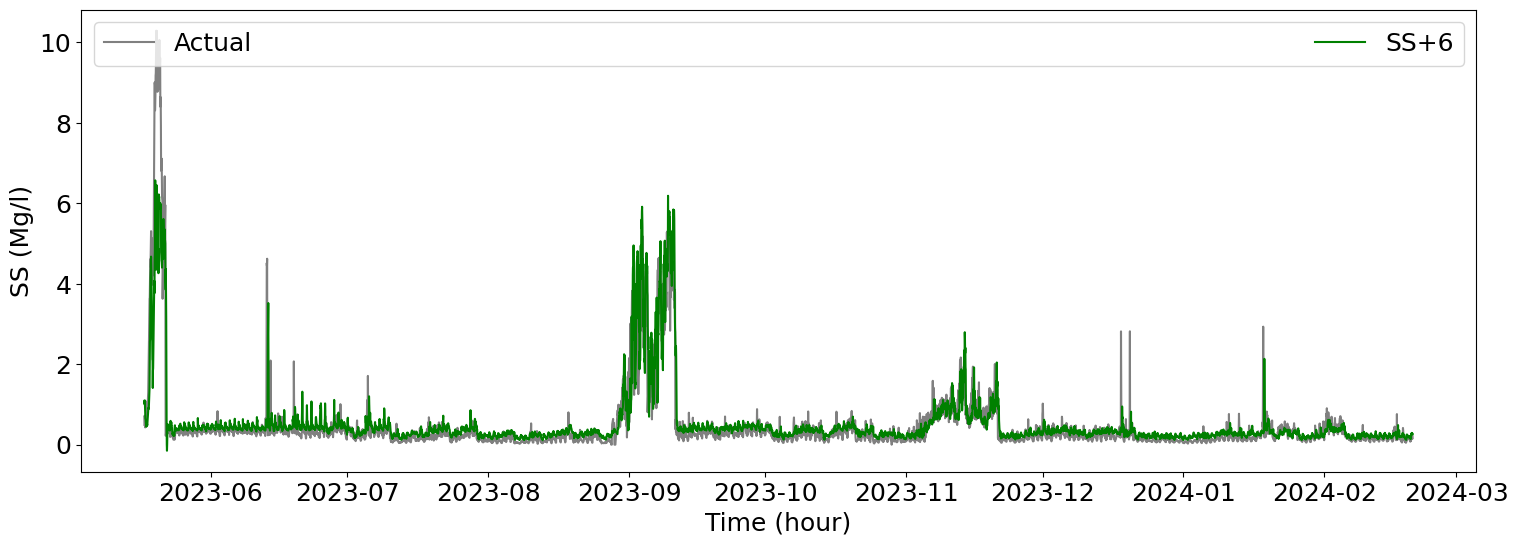

In [35]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'SS'
forcastlength = 6
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,y_test[TS], color = 'gray', label = 'Actual')
plt.plot(time,dfxgb_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [36]:

import plotly.graph_objects as go
import plotly.express as px

fig = px.line(dfxgb_y_pred, x=dfxgb_y_pred.index, y=TS)
fig.add_scatter(x=dfxgb_y_pred.index, y=y_test[TS]) # No

# # Show plot 
fig.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = r2_score(y_test[index], dfxgb_y_pred[index]) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: 0.8096286595855007
TOC+2: 0.7048011001021547
TOC+3: 0.6786473590846924
TOC+4: 0.6615819908885622
TOC+5: 0.6317066501537892
TOC+6: 0.6153498564028326
--------------------------
TN+1: 0.8942028290995214
TN+2: 0.8066566283780514
TN+3: 0.7976447685645829
TN+4: 0.7900290976263414
TN+5: 0.7508874270489578
TN+6: 0.7371150047209515
--------------------------
TP+1: 0.6134107460027761
TP+2: 0.43510475698551565
TP+3: 0.3071096841771064
TP+4: 0.23097944641689228
TP+5: 0.15443301411701538
TP+6: 0.12777246790601104
--------------------------
SS+1: 0.9352381075480674
SS+2: 0.8882829209607823
SS+3: 0.8529407860525954
SS+4: 0.8273790846499764
SS+5: 0.7945913887997165
SS+6: 0.7700182232530001
--------------------------
